In [2]:
# Imports
from convnwb.io import load_nwbfile, make_session_name

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
sns.set_context('talk')

from convnwb.io import load_nwbfile
from convnwb.io import get_files, save_json

from spiketools.stats.shuffle import shuffle_spikes
from spiketools.plts.trials import plot_rasters, create_raster_title
from spiketools.plts.trials import plot_rate_by_time
from spiketools.plts.spatial import plot_position_by_time, plot_position_1d, plot_positions, plot_heatmap,create_heatmap_title
from spiketools.utils.timestamps import convert_sec_to_min, sum_time_ranges
from spiketools.plts.data import plot_bar, plot_hist, plot_text, plot_barh,plot_lines
from spiketools.plts.utils import make_grid, get_grid_subplot
from spiketools.spatial.utils import compute_pos_ranges, compute_bin_width
from spiketools.measures.trials import compute_segment_frs
from spiketools.measures.spikes import compute_firing_rate
from spiketools.plts.spatial import plot_position_by_time,plot_heatmap,create_heatmap_title
from spiketools.utils.extract import get_range
from spiketools.utils.epoch import epoch_spikes_by_range, epoch_spikes_by_event
from spiketools.plts.utils import save_figure
from spiketools.plts.data import plot_barh
from spiketools.plts.trials import plot_rasters
from spiketools.plts.annotate import add_vlines,add_box_shades
from spiketools.utils.extract import (get_range, get_values_by_time_range,
                                      get_values_by_times, threshold_spikes_by_values)
from spiketools.spatial.occupancy import compute_occupancy,compute_trial_occupancy, compute_bin_edges,compute_bin_counts_pos, normalize_bin_counts
from spiketools.utils.extract import get_range, get_values_by_time_range, get_values_by_times,get_inds_by_times
from spiketools.stats.trials import compare_pre_post_activity
from spiketools.measures.trials import compute_trial_frs

from spiketools.plts.style import drop_spines
from spiketools.plts.annotate import color_pvalue

In [4]:
import sys
sys.path.append('../code')
from plts import plot_spikes_trial,plot_task_structure,plot_positions_with_speed
from utils import group_array_by_key,select_movement
from reports import create_sess_str
from trial import get_trial_structure
from group import get_all_session_paths


# Settings 

In [5]:
base_path = "/Users/weijiazhang/Data/Train/nwb"

In [6]:
session = {
    'experiment' : 'TRAIN',
    'subject' : 'UT088',
    'session' : '0'    
}



In [7]:
experiment = session['experiment']
subject = session['subject']
sess = session['session']
session_name = make_session_name(subject,experiment,sess)
session_name

'TRAIN_UT088_session_0'

In [8]:
# Set which example unit to extract 
uind = 0

In [9]:
# Define bins to use
num_bins = 40

# Define minimum occupancy
min_occ = 1
speed_thresh = 5e-6
time_thresh = 0.25

# TEMP:
speed_thresh = 0

# Set the time range to analyze
trial_range = [-1, 1]
pre_window = [-1, 0]
post_window = [0, 1]

In [10]:
# Shuffle settings
shuffle_approach = 'BINCIRC'
n_surrogates = 25

In [11]:
# Get the list of NWB files
nwbfiles = get_files(base_path,select = 'nwb')
nwbfiles

['TRAIN_EU001_session_0.nwb',
 'TRAIN_R1027J_session_0.nwb',
 'TRAIN_R1027J_session_1.nwb',
 'TRAIN_R1030J_session_0.nwb',
 'TRAIN_R1030J_session_1.nwb',
 'TRAIN_R1030J_session_2.nwb',
 'TRAIN_R1139C_session_0.nwb',
 'TRAIN_R1139C_session_1.nwb',
 'TRAIN_R1152C_session_0.nwb',
 'TRAIN_R1182C_session_0.nwb',
 'TRAIN_R1219C_session_0.nwb',
 'TRAIN_R1241J_session_0.nwb',
 'TRAIN_R1268T_session_0.nwb',
 'TRAIN_R1278E_session_0.nwb',
 'TRAIN_R1278E_session_1.nwb',
 'TRAIN_R1278E_session_3.nwb',
 'TRAIN_R1297T_session_0.nwb',
 'TRAIN_R1299T_session_0.nwb',
 'TRAIN_R1315T_session_0.nwb',
 'TRAIN_R1315T_session_1.nwb',
 'TRAIN_R1354E_session_0.nwb',
 'TRAIN_R1354E_session_1.nwb',
 'TRAIN_R1362E_session_0.nwb',
 'TRAIN_R1362E_session_1.nwb',
 'TRAIN_R1414E_session_1.nwb',
 'TRAIN_UT088_session_0.nwb']

# Load Data 

In [12]:
# Load NWB file
nwbfile = load_nwbfile(session, base_path)

/Users/weijiazhang/anaconda3/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.1 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/Users/weijiazhang/anaconda3/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.5.0 because version 2.6.0-alpha is already loaded.
  return func(args[0], **pargs)
/Users/weijiazhang/anaconda3/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.2.0 because version 0.5.0 is already loaded.
  return func(args[0], **pargs)
/Users/weijiazhang/anaconda3/lib/python3.11/site-packages/pynwb/base.py:195: UserWarning: Timeseries has a rate of 0.0 Hz, but the length of the data is greater than 1.
  warn('Timeseries has a rate of 0.0 Hz, but the length of the data is greater than 1.')


## Trial Data 

In [13]:
# Get start and stop time of trials
trial_starts = nwbfile.trials['start_time'].data[:]
trial_stops = nwbfile.trials['stop_time'].data[:]

In [14]:
# Get the navigation time ranges
move_starts = nwbfile.trials.movement_start_time[:]
move_stops = nwbfile.trials.movement_stop_time[:]

## Position Data 

In [15]:
# Position data
pos = nwbfile.acquisition['position']['player_position']
ptimes = pos.timestamps[:]
positions = pos.data[:]
print(ptimes.shape)
print(ptimes.shape)

(7947,)
(7947,)


In [16]:
ptimes_trials, positions_trials = select_movement(\
    nwbfile.acquisition['position']['player_position'], move_starts, move_stops,True)
print(ptimes_trials.shape)
print(positions_trials.shape)

(7947,)
(7947,)


In [17]:
x_min_track, x_max_track = compute_pos_ranges(positions)
track_range = [x_min_track, x_max_track]

## Speed Data

Text(0, 0.5, 'Frequency')

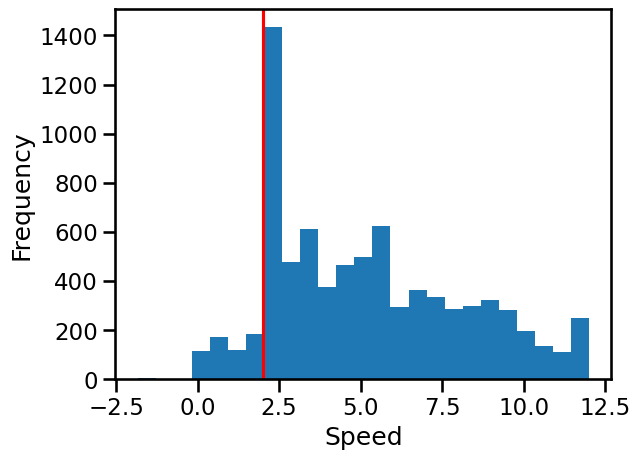

In [18]:
speed_thresh = 2
speed = nwbfile.processing['position_measures']['speed'].data[:]
plot_hist(speed, bins=25)
add_vlines(speed_thresh, color='red')
plt.xlabel('Speed')
plt.ylabel('Frequency')

## Get object related information 

In [19]:
# Get trial indices of interest
obj = nwbfile.trials.object[:]

# Get the object positions 
obj_pos = nwbfile.trials.object_position[:]

# Get subject response position and time 
res_pos = nwbfile.trials.response_position[:]
res_time = nwbfile.trials.response_time[:]

## Get Spikes 

In [20]:
# Extract spikes for a unit of interest
spikes = nwbfile.units.get_unit_spike_times(uind)

# Precompute Some Things 

In [21]:
# Get the spiking data for each movement period 
spikes_move = epoch_spikes_by_range(spikes, move_starts, move_stops, reset=True)
print(len(spikes_move))

64


In [22]:
# Get the spiking data and spiking positions for all movement period 
move_spikes = []
move_spike_pos = []
for ind in range(len(spikes_move)): 
    m_spikes = get_range(spikes, move_starts[ind],move_stops[ind])
    move_spike_pos.append(get_values_by_times(ptimes, positions, m_spikes,time_threshold = .1))
    move_spikes.append(m_spikes)
    move_spikes_all = np.concatenate(move_spikes).ravel()


In [23]:
# Create shuffled time series for comparison
times_shuffle = shuffle_spikes(move_spikes_all, shuffle_approach, n_surrogates)

In [24]:
# Epoch around subject response time 
all_responses = epoch_spikes_by_event(spikes, res_time, trial_range)

In [25]:
# Compute bin edges
bin_edges = compute_bin_edges(positions,num_bins)

In [26]:
# Get position values for each spike
spike_pos= get_values_by_times(ptimes, positions, spikes, time_threshold=time_thresh)

In [27]:
# Compute occupancy
occ = compute_occupancy(positions, ptimes, num_bins)
occ

array([ 74.59886475,  25.19961499,  20.69968457,  19.69970068,
        19.89969604,  19.19970776,  19.29970459,  19.29970923,
        20.29968799,  20.0996958 ,  21.59966821,  20.59968823,
        21.59967139,  17.39973657,  17.69972827,  19.19970654,
        21.19967773,  20.1996936 ,  19.69969971,  19.69969995,
        19.59970044,  19.79970044,  19.79969482,  21.89966699,
        20.59968848,  24.29962769,  19.39970605,  19.09970898,
        19.99969482,  19.99969434,  19.79969995,  19.699698  ,
        19.69970044,  19.89969873,  19.59969922,  19.69969946,
       262.99599341, 443.09324976, 603.39080762, 626.39045752])

In [28]:
# Compute spatial bin assignments & binned firing, and normalize by occupancy
place_bins = compute_bin_counts_pos(spike_pos, num_bins, track_range, occ)

# Object Related Visualization 

## Individual Object Location

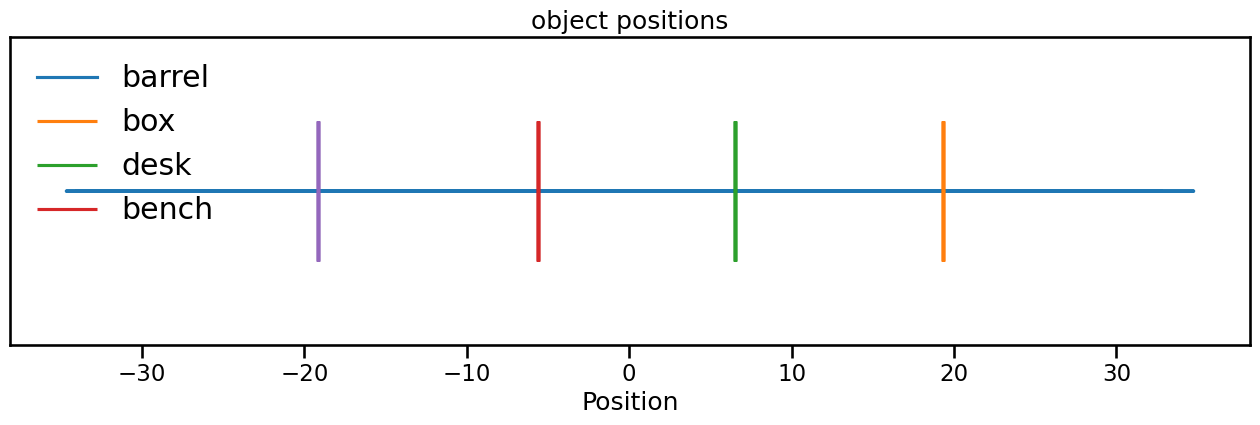

In [29]:
obj_loc = group_array_by_key(obj, obj_pos)
barrel_loc = np.array(obj_loc['barrel'][:])
box_loc = np.array(obj_loc['box'][:])
desk_loc= np.array(obj_loc['desk'][:])
bench_loc = np.array(obj_loc['bench'][:])

plot_position_1d(positions, [barrel_loc,box_loc,desk_loc,bench_loc], figsize=(16, 4))
plt.title('object positions')
plt.legend(['barrel', 'box', 'desk', 'bench'], loc='upper left', frameon=False, fontsize='large')


## Subjects' Response Location 

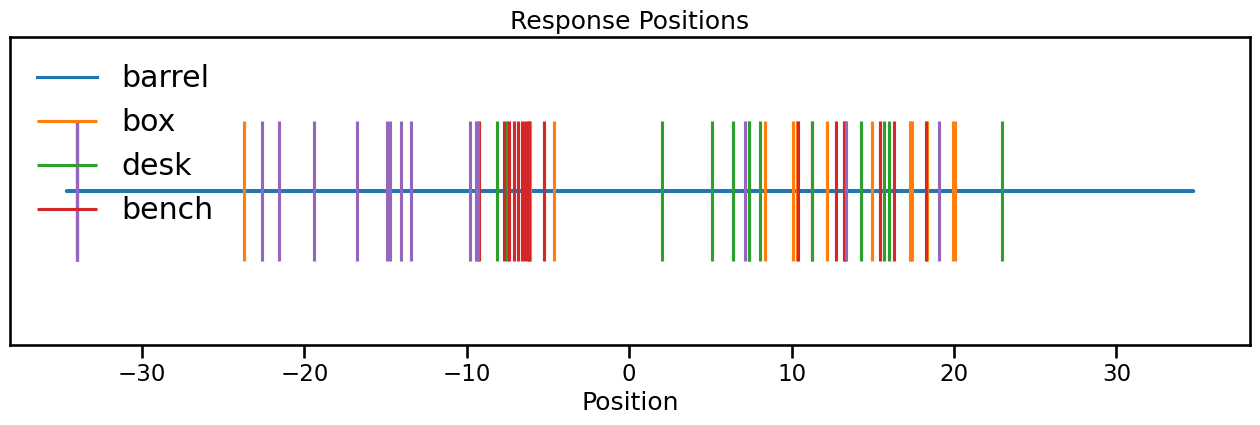

In [30]:
res_loc = group_array_by_key(obj, res_pos)
res_barrel_loc = np.array(res_loc['barrel'][:])
res_box_loc= np.array(res_loc['box'][:])
res_desk_loc = np.array(res_loc['desk'][:])
res_bench_loc = np.array(res_loc['bench'][:])
plot_position_1d(positions, [res_barrel_loc, res_box_loc, res_desk_loc, res_bench_loc],
                 title='Response Positions', figsize=(16, 4))
plt.legend(['barrel', 'box', 'desk', 'bench'], loc='upper left', frameon=False, fontsize='large')


## Subjects' Response Error 

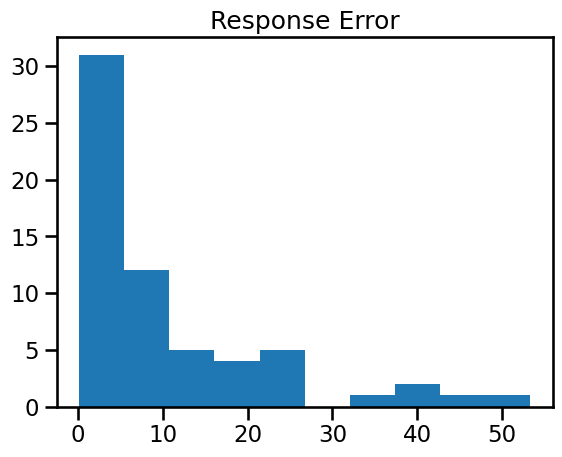

In [31]:
# plot response error
plot_hist(nwbfile.trials['response_error'].data[:], title='Response Error')

# Statistical Measures - Response Time 

## All Trials - Response Time

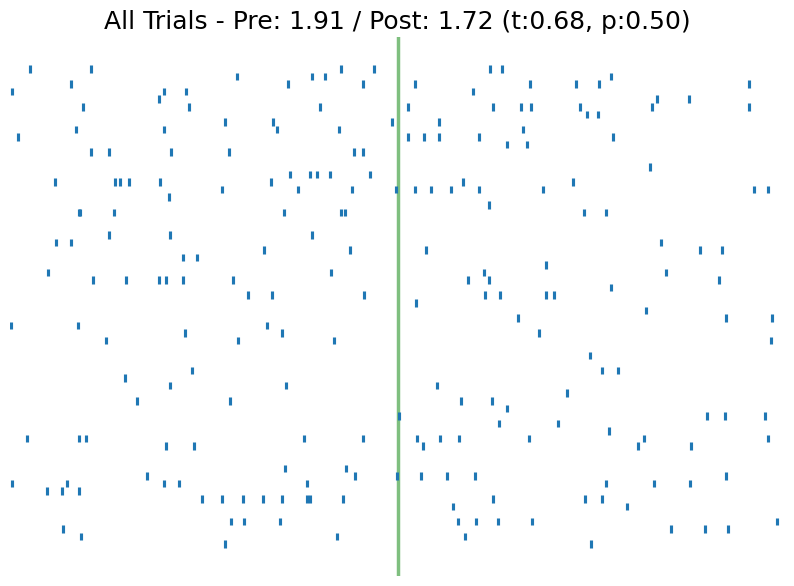

In [32]:
# Compute averages & statistical comparison of pre / post window firing rates
avg_pre, avg_post, t_val, p_val = compare_pre_post_activity(all_responses, pre_window, post_window)
# Plot raster across all response prompts
plot_rasters(all_responses, xlim=trial_range, vline=0, figsize=(10, 7), 
             title=create_raster_title('All Trials', avg_pre, avg_post, t_val, p_val))

bin_times, all_frs = compute_trial_frs(all_responses, 0.25, time_range=[-1,1])

In [33]:
bin_times

array([-0.875, -0.625, -0.375, -0.125,  0.125,  0.375,  0.625,  0.875])

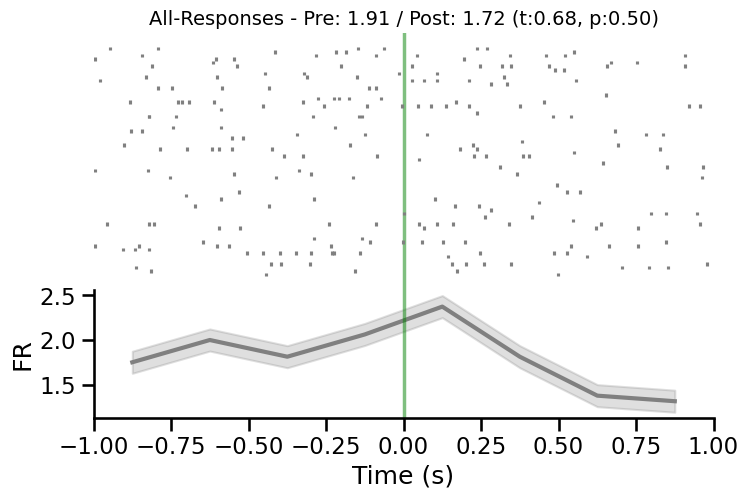

In [34]:
grid = make_grid(3, 1, figsize=(8, 5), hspace=0)
plot_rasters(all_responses,  xlim=trial_range, vline=0, 
             colors= 'grey',title = create_raster_title('All-Responses', avg_pre, avg_post,
                                       t_val, p_val),
             title_color=color_pvalue(p_val), title_fontsize=14,
             ax=get_grid_subplot(grid, slice(0, 2), 0))
plot_rate_by_time(bin_times, all_frs.mean(0), shade='sem',ax=get_grid_subplot(grid, 2, 0), colors='grey')
add_vlines(0, ax=get_grid_subplot(grid, 2,0), color='green', lw=2.5, alpha=0.5)
get_grid_subplot(grid, 2, 0).set(xlim=[-1,1])
get_grid_subplot(grid, 2, 0).set(xlabel='Time (s)', ylabel='FR')
drop_spines(['top', 'right',],get_grid_subplot(grid, 2, 0))

## Group Subjects' response time by objects 

In [35]:
subj_res = group_array_by_key(obj, res_time)
barrel_res =  np.array(subj_res['barrel'][:])
box_res =  np.array(subj_res['box'][:])
bench_res =  np.array(subj_res['bench'][:])
desk_res =  np.array(subj_res['desk'][:])

In [36]:
# Get grouped trial spikes 
barrel_t = epoch_spikes_by_event(spikes, barrel_res, trial_range)
box_t = epoch_spikes_by_event(spikes, box_res, trial_range)
bench_t = epoch_spikes_by_event(spikes, bench_res , trial_range)
desk_t = epoch_spikes_by_event(spikes, desk_res, trial_range)

In [37]:
results = {}
avg_pre_barrel, avg_post_barrel, results['t_val_barrel'],results['p_val_barrel'] = compare_pre_post_activity(barrel_t, pre_window, post_window)
avg_pre_box, avg_post_box, results['t_val_box'], results['p_val_box']= compare_pre_post_activity(box_t, pre_window, post_window)
avg_pre_bench, avg_post_bench, results['t_val_bench'],results['p_val_bench'] = compare_pre_post_activity(bench_t, pre_window, post_window)
avg_pre_desk, avg_post_desk, results['t_val_desk'],results['p_val_desk'] = compare_pre_post_activity(desk_t, pre_window, post_window)

In [38]:
# Computes continuous firing rate across trials 
bin_times, barrel_frs = compute_trial_frs(barrel_t, 0.25, time_range=[-1,1])
bin_times, box_frs = compute_trial_frs(box_t, 0.25, time_range=[-1,1])
bin_times, bench_frs = compute_trial_frs(bench_t, 0.25, time_range=[-1,1])
bin_times, desk_frs = compute_trial_frs(desk_t, 0.25, time_range=[-1,1])


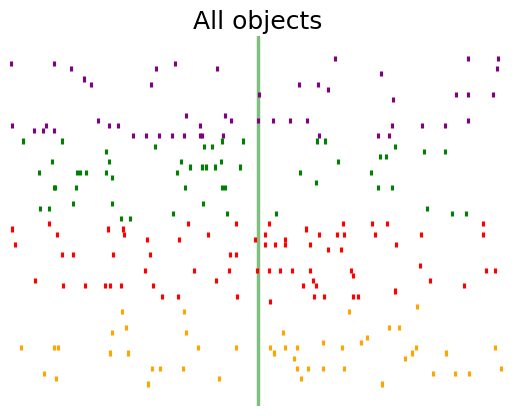

In [39]:
plot_rasters([barrel_t , box_t, bench_t, desk_t], xlim=trial_range, vline=0, 
             colors= ['orange','red','green','purple'],title = 'All objects',
             )

### Barrel

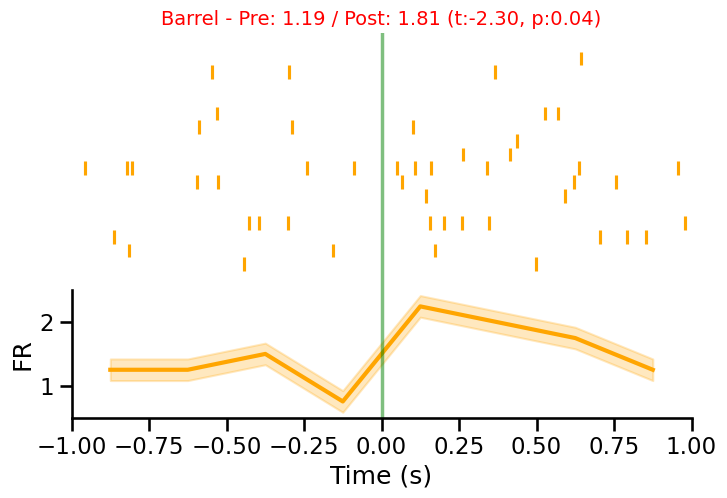

In [40]:
grid = make_grid(3, 1, figsize=(8, 5), hspace=0)
plot_rasters(barrel_t,  xlim=trial_range, vline=0, 
             colors= 'orange',title = create_raster_title('Barrel', avg_pre_barrel, avg_post_barrel,
                                       results['t_val_barrel'], results['p_val_barrel']),
             title_color=color_pvalue(results['p_val_barrel']), title_fontsize=14,
             ax=get_grid_subplot(grid, slice(0, 2), 0))
plot_rate_by_time(bin_times, barrel_frs.mean(0), shade='sem',ax=get_grid_subplot(grid, 2, 0), colors='orange')
add_vlines(0, ax=get_grid_subplot(grid, 2,0), color='green', lw=2.5, alpha=0.5)
get_grid_subplot(grid, 2, 0).set(xlim=[-1,1])
get_grid_subplot(grid, 2, 0).set(xlabel='Time (s)', ylabel='FR')
drop_spines(['top', 'right',],get_grid_subplot(grid, 2, 0))

### Box

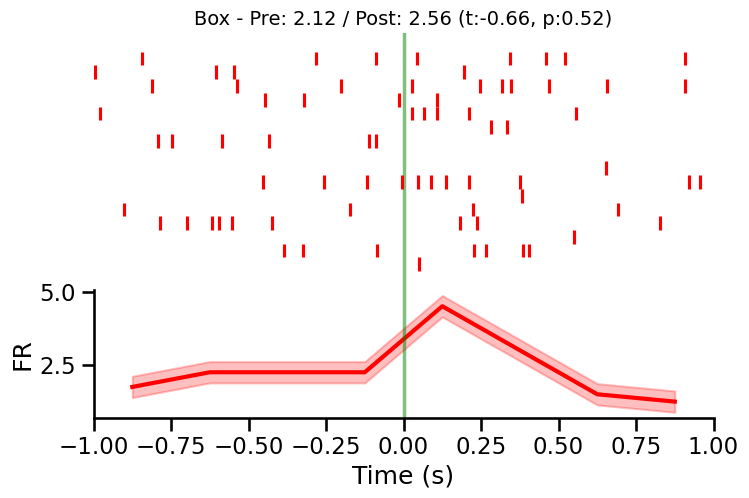

In [41]:
grid = make_grid(3, 1, figsize=(8, 5), hspace=0)
plot_rasters(box_t,  xlim=trial_range, vline=0, 
             colors= 'red',title = create_raster_title('Box', avg_pre_box, avg_post_box,
                                       results['t_val_box'], results['p_val_box']),
             title_color=color_pvalue(results['p_val_box']), title_fontsize=14,
             ax=get_grid_subplot(grid, slice(0, 2), 0))

plot_rate_by_time(bin_times, box_frs.mean(0), shade='sem', 
                  ax=get_grid_subplot(grid, 2, 0), colors='red')
add_vlines(0, ax=get_grid_subplot(grid, 2,0), color='green', lw=2.5, alpha=0.5)
get_grid_subplot(grid, 2, 0).set(xlim=[-1,1])
get_grid_subplot(grid, 2, 0).set(xlabel='Time (s)', ylabel='FR')
drop_spines(['top', 'right',],get_grid_subplot(grid, 2, 0))


### Bench

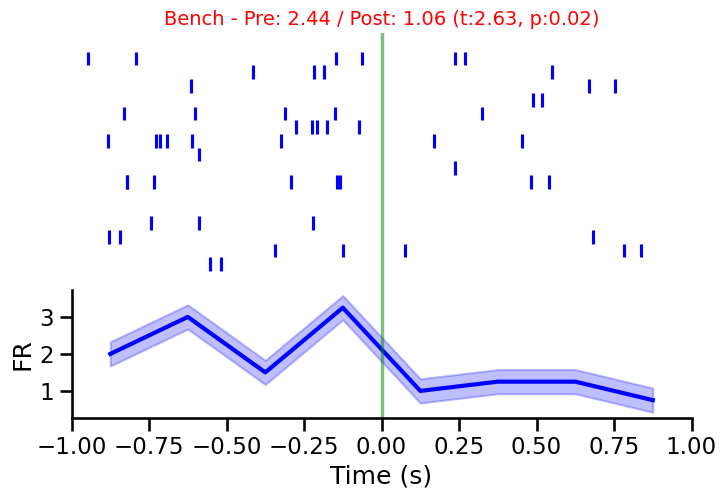

In [42]:
grid = make_grid(3, 1, figsize=(8, 5), hspace=0)
plot_rasters(bench_t,  xlim=trial_range, vline=0, 
             colors= 'blue',title = create_raster_title('Bench', avg_pre_bench, avg_post_bench,
                                       results['t_val_bench'], results['p_val_bench']),
             title_color=color_pvalue(results['p_val_bench']), title_fontsize=14,
             ax=get_grid_subplot(grid, slice(0, 2), 0))
plot_rate_by_time(bin_times, bench_frs.mean(0), shade='sem', 
                  ax=get_grid_subplot(grid, 2, 0), colors='blue')
add_vlines(0, ax=get_grid_subplot(grid, 2,0), color='green', lw=2.5, alpha=0.5)
get_grid_subplot(grid, 2, 0).set(xlim=[-1,1])
get_grid_subplot(grid, 2, 0).set(xlabel='Time (s)', ylabel='FR')
drop_spines(['top', 'right',],get_grid_subplot(grid, 2, 0))

### Desk 

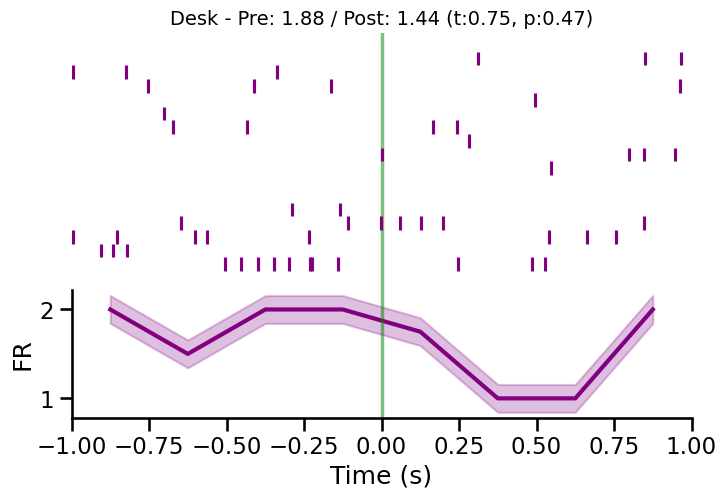

In [43]:
grid = make_grid(3, 1, figsize=(8, 5), hspace=0)
plot_rasters(desk_t,  xlim=trial_range, vline=0, 
             colors= 'purple',title = create_raster_title('Desk', avg_pre_desk, avg_post_desk,
                                       results['t_val_desk'], results['p_val_desk']),
             title_color=color_pvalue(results['p_val_desk']), title_fontsize=14,
             ax=get_grid_subplot(grid, slice(0, 2), 0))

plot_rate_by_time(bin_times, desk_frs.mean(0), shade='sem', 
                  ax=get_grid_subplot(grid, 2, 0), colors='purple')
add_vlines(0, ax=get_grid_subplot(grid, 2,0), color='green', lw=2.5, alpha=0.5)
get_grid_subplot(grid, 2, 0).set(xlim=[-1,1])
get_grid_subplot(grid, 2, 0).set(xlabel='Time (s)', ylabel='FR')
drop_spines(['top', 'right',],get_grid_subplot(grid, 2, 0))

## Encoding vs. Recall 
- encoding trials: 
    - The first two times that participans encontered a particular object were encoding trials, in which the object was visible during movement.
    - In subsequent retrieval trials, the object was inivisible and participants were instructed to recall its location by pressing the controller button when they believed they were at the correct location.


In [44]:
# Separate into encode and recall trials
barrel_encode = barrel_t[:2]
barrel_recall = barrel_t[2:]

box_encode = box_t[:2]
box_recall = box_t[2:]

bench_encode = bench_t[:2]
bench_recall = bench_t[2:]

desk_encode = desk_t[:2]
desk_recall = desk_t[2:]

all_encode =  barrel_encode + box_encode + bench_encode + desk_encode
all_recall =  barrel_recall + box_recall + bench_recall + desk_recall


In [45]:
len(all_recall)

56

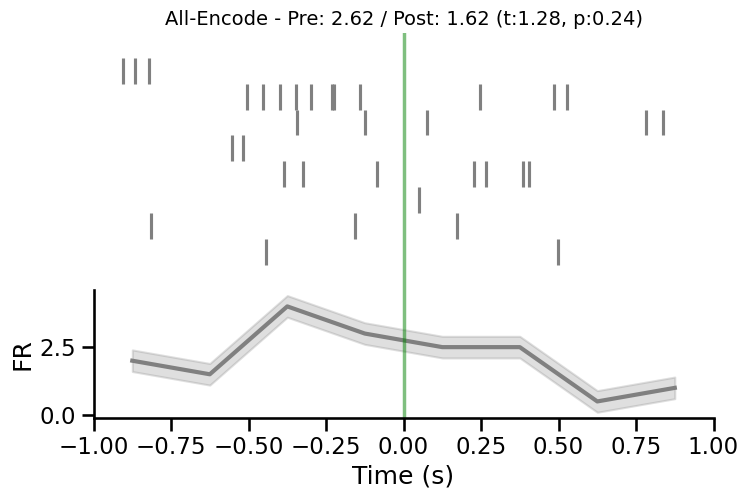

In [46]:
# Compute averages & statistical comparison of pre / post window firing rates
avg_pre, avg_post, t_val, p_val = compare_pre_post_activity(all_encode, pre_window, post_window)
bin_times, encode_frs = compute_trial_frs(all_encode, 0.25, time_range=[-1,1])
# Plot raster across all response prompts
grid = make_grid(3, 1, figsize=(8, 5), hspace=0)
plot_rasters(all_encode,  xlim=trial_range, vline=0, 
             colors= 'grey',title = create_raster_title('All-Encode', avg_pre, avg_post,
                                       t_val, p_val),
             title_color=color_pvalue(p_val), title_fontsize=14,
             ax=get_grid_subplot(grid, slice(0, 2), 0))
plot_rate_by_time(bin_times, encode_frs.mean(0), shade='sem',ax=get_grid_subplot(grid, 2, 0), colors='grey')
add_vlines(0, ax=get_grid_subplot(grid, 2,0), color='green', lw=2.5, alpha=0.5)
get_grid_subplot(grid, 2, 0).set(xlim=[-1,1])
get_grid_subplot(grid, 2, 0).set(xlabel='Time (s)', ylabel='FR')
drop_spines(['top', 'right',],get_grid_subplot(grid, 2, 0))

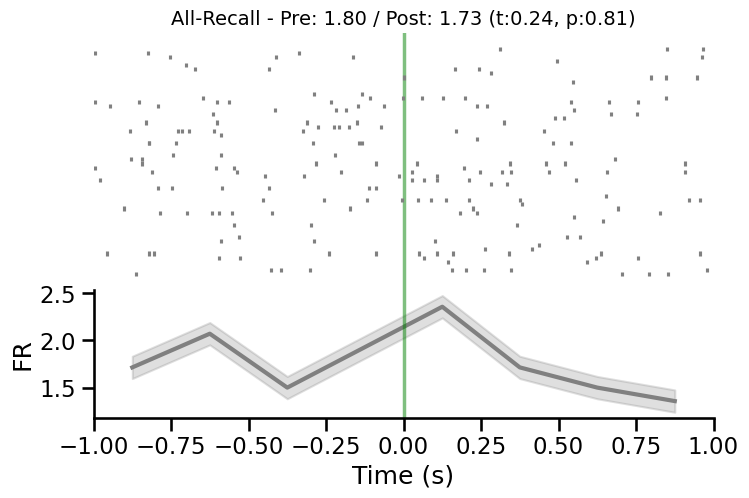

In [47]:
# Compute averages & statistical comparison of pre / post window firing rates
avg_pre, avg_post, t_val, p_val = compare_pre_post_activity(all_recall, pre_window, post_window)
bin_times, rec_frs = compute_trial_frs(all_recall, 0.25, time_range=[-1,1])
# Plot raster across all response prompts
grid = make_grid(3, 1, figsize=(8, 5), hspace=0)
plot_rasters(all_recall,  xlim=trial_range, vline=0, 
             colors= 'grey',title = create_raster_title('All-Recall', avg_pre, avg_post,
                                       t_val, p_val),
             title_color=color_pvalue(p_val), title_fontsize=14,
             ax=get_grid_subplot(grid, slice(0, 2), 0))
plot_rate_by_time(bin_times, rec_frs.mean(0), shade='sem',ax=get_grid_subplot(grid, 2, 0), colors='grey')
add_vlines(0, ax=get_grid_subplot(grid, 2,0), color='green', lw=2.5, alpha=0.5)
get_grid_subplot(grid, 2, 0).set(xlim=[-1,1])
get_grid_subplot(grid, 2, 0).set(xlabel='Time (s)', ylabel='FR')
drop_spines(['top', 'right',],get_grid_subplot(grid, 2, 0))

In [48]:
results_encode = {}
fr_pre_barrel_encode, fr_post_barrel_encode, results_encode['t_val_barrel'],results_encode['p_val_barrel'] = compare_pre_post_activity(barrel_encode, pre_window, post_window)
fr_pre_box_encode, fr_post_box_encode, results_encode['t_val_box'], results_encode['p_val_box']= compare_pre_post_activity(box_encode, pre_window, post_window)
fr_pre_bench_encode, fr_post_bench_encode, results_encode['t_val_bench'],results_encode['p_val_bench'] = compare_pre_post_activity(bench_encode, pre_window, post_window)
fr_pre_desk_encode, fr_post_desk_encode, results_encode['t_val_desk'],results_encode['p_val_desk'] = compare_pre_post_activity(desk_encode, pre_window, post_window)


results_recall = {}
fr_pre_barrel_recall, fr_post_barrel_recall, results_recall['t_val_barrel'],results_recall['p_val_barrel'] = compare_pre_post_activity(barrel_recall, pre_window, post_window)
fr_pre_box_recall, fr_post_box_recall, results_recall['t_val_box'], results_recall['p_val_box']= compare_pre_post_activity(box_recall, pre_window, post_window)
fr_pre_bench_recall, fr_post_bench_recall, results_recall['t_val_bench'],results_recall['p_val_bench'] = compare_pre_post_activity(bench_recall, pre_window, post_window)
fr_pre_desk_recall, fr_post_desk_recall, results_recall['t_val_desk'],results_recall['p_val_desk'] = compare_pre_post_activity(desk_recall, pre_window, post_window)


# Computes continuous firing rate across trials 
bin_times, barrel_frs_encode = compute_trial_frs(barrel_encode, 0.25, time_range=[-1,1])
bin_times, box_frs_encode = compute_trial_frs(box_encode, 0.25, time_range=[-1,1])
bin_times, bench_frs_encode = compute_trial_frs(bench_encode, 0.25, time_range=[-1,1])
bin_times, desk_frs_encode = compute_trial_frs(desk_encode, 0.25, time_range=[-1,1])

# Computes continuous firing rate across trials 
bin_times, barrel_frs_recall = compute_trial_frs(barrel_recall, 0.25, time_range=[-1,1])
bin_times, box_frs_recall = compute_trial_frs(box_recall, 0.25, time_range=[-1,1])
bin_times, bench_frs_recall = compute_trial_frs(bench_recall, 0.25, time_range=[-1,1])
bin_times, desk_frs_recall = compute_trial_frs(desk_recall, 0.25, time_range=[-1,1])

/Users/weijiazhang/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


### Barrel 

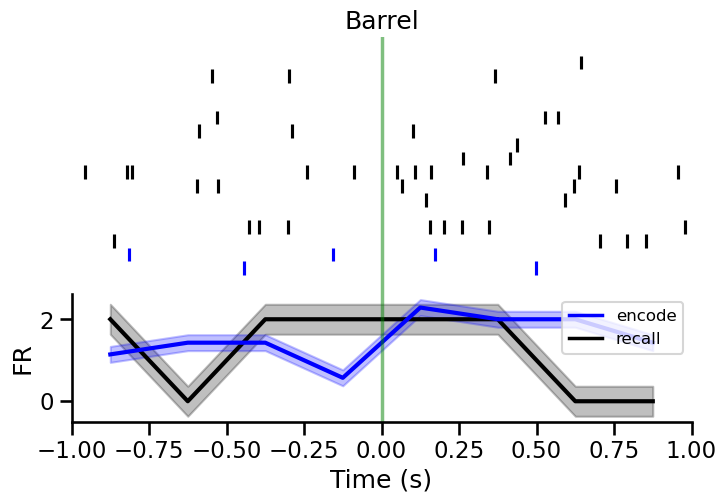

In [49]:
# Barrel 
grid = make_grid(3, 1, figsize=(8, 5), hspace=0)
plot_rasters([barrel_encode,barrel_recall], xlim=trial_range, vline=0, 
             colors= ['blue','black'],title = 'Barrel',
             ax=get_grid_subplot(grid, slice(0, 2), 0))

plot_rate_by_time(bin_times, [barrel_frs_encode.mean(0),barrel_frs_recall.mean(0)], shade='sem', 
                  ax=get_grid_subplot(grid, 2, 0), colors=['black','blue'])
add_vlines(0, ax=get_grid_subplot(grid, 2,0), color='green', lw=2.5, alpha=0.5)
get_grid_subplot(grid, 2, 0).set(xlim=[-1,1])
get_grid_subplot(grid, 2, 0).set(xlabel='Time (s)', ylabel='FR')

legend_elements = [Line2D([0], [0], color='blue', lw=2.5, label='encode'),
                   Line2D([0], [0], color='black', lw=2.5, label='recall')]
plt.legend(handles=legend_elements, loc='upper right', ncol=1, fontsize=12)
drop_spines(['top', 'right'],get_grid_subplot(grid, 2, 0))



### Box 

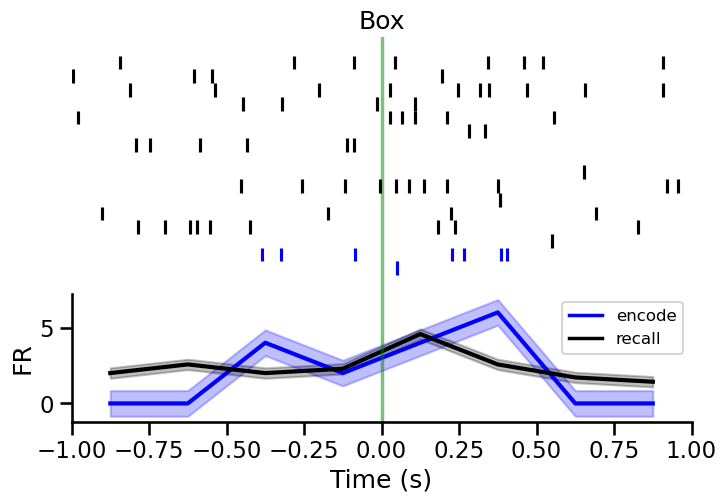

In [50]:
# Box 
grid = make_grid(3, 1, figsize=(8, 5), hspace=0)
plot_rasters([box_encode,box_recall], xlim=trial_range, vline=0, 
             colors= ['blue','black'],title = 'Box',
             ax=get_grid_subplot(grid, slice(0, 2), 0))

plot_rate_by_time(bin_times, [box_frs_encode.mean(0),box_frs_recall.mean(0)], shade='sem', 
                  ax=get_grid_subplot(grid, 2, 0), colors=['blue','black'])
add_vlines(0, ax=get_grid_subplot(grid, 2,0), color='green', lw=2.5, alpha=0.5)
get_grid_subplot(grid, 2, 0).set(xlim=[-1,1])
get_grid_subplot(grid, 2, 0).set(xlabel='Time (s)', ylabel='FR')

legend_elements = [Line2D([0], [0], color='blue', lw=2.5, label='encode'),
                  Line2D([0], [0], color='black', lw=2.5, label='recall')]
plt.legend(handles=legend_elements, loc='upper right', ncol=1, fontsize=12)
drop_spines(['top', 'right'],get_grid_subplot(grid, 2, 0))



### Bench

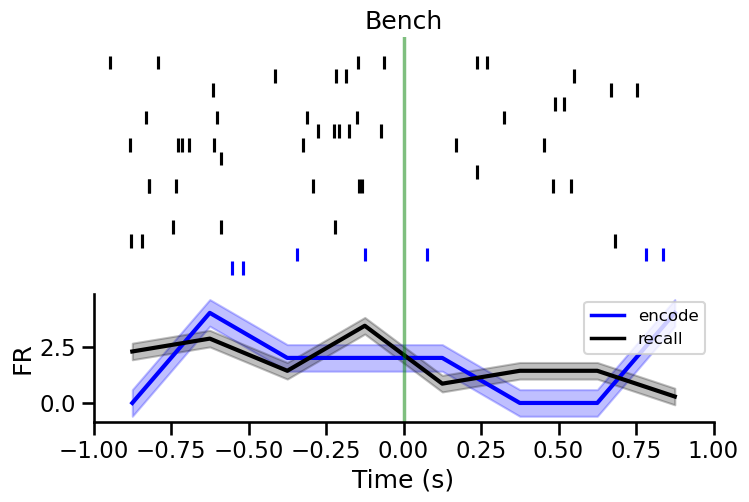

In [51]:
grid = make_grid(3, 1, figsize=(8, 5), hspace=0)
plot_rasters([bench_encode,bench_recall], xlim=trial_range, vline=0, 
             colors= ['blue','black'],title = 'Bench',
             ax=get_grid_subplot(grid, slice(0, 2), 0))

plot_rate_by_time(bin_times, [bench_frs_encode.mean(0),bench_frs_recall.mean(0)], shade='sem', 
                  ax=get_grid_subplot(grid, 2, 0), colors=['blue','black'])
add_vlines(0, ax=get_grid_subplot(grid, 2,0), color='green', lw=2.5, alpha=0.5)
get_grid_subplot(grid, 2, 0).set(xlim=[-1,1])
get_grid_subplot(grid, 2, 0).set(xlabel='Time (s)', ylabel='FR')

legend_elements = [Line2D([0], [0], color='blue', lw=2.5, label='encode'),
                  Line2D([0], [0], color='black', lw=2.5, label='recall')]
plt.legend(handles=legend_elements, loc='upper right', ncol=1, fontsize=12)
drop_spines(['top', 'right'],get_grid_subplot(grid, 2, 0))


### Desk 

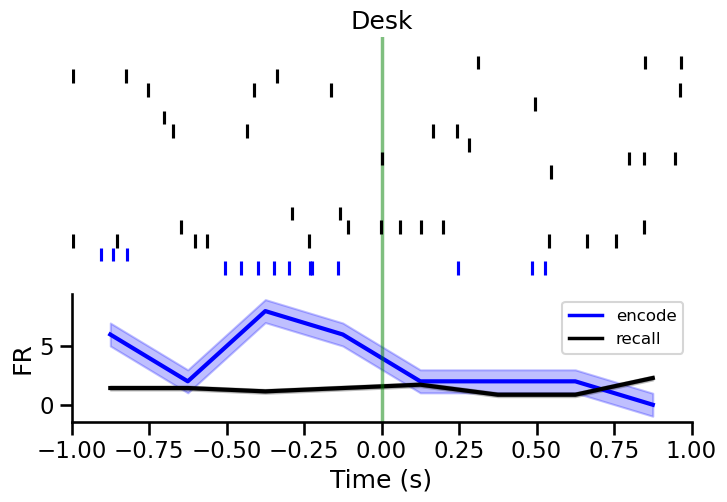

In [52]:
# Desk
grid = make_grid(3, 1, figsize=(8, 5), hspace=0)
plot_rasters([desk_encode,desk_recall], xlim=trial_range, vline=0, 
             colors= ['blue','black'],title = 'Desk',
             ax=get_grid_subplot(grid, slice(0, 2), 0))

plot_rate_by_time(bin_times, [desk_frs_encode.mean(0),desk_frs_recall.mean(0)], shade='sem', ax=get_grid_subplot(grid, 2, 0), colors=['blue','black'])
add_vlines(0, ax=get_grid_subplot(grid, 2,0), color='green', lw=2.5, alpha=0.5)
get_grid_subplot(grid, 2, 0).set(xlim=[-1,1])
get_grid_subplot(grid, 2, 0).set(xlabel='Time (s)', ylabel='FR')

legend_elements = [Line2D([0], [0], color='blue', lw=2.5, label='encode'),
                   Line2D([0], [0], color='black', lw=2.5, label='recall')]
drop_spines(['top', 'right'],get_grid_subplot(grid, 2, 0))
plt.legend(handles=legend_elements, loc='upper right', ncol=1, fontsize=12)

# Report 

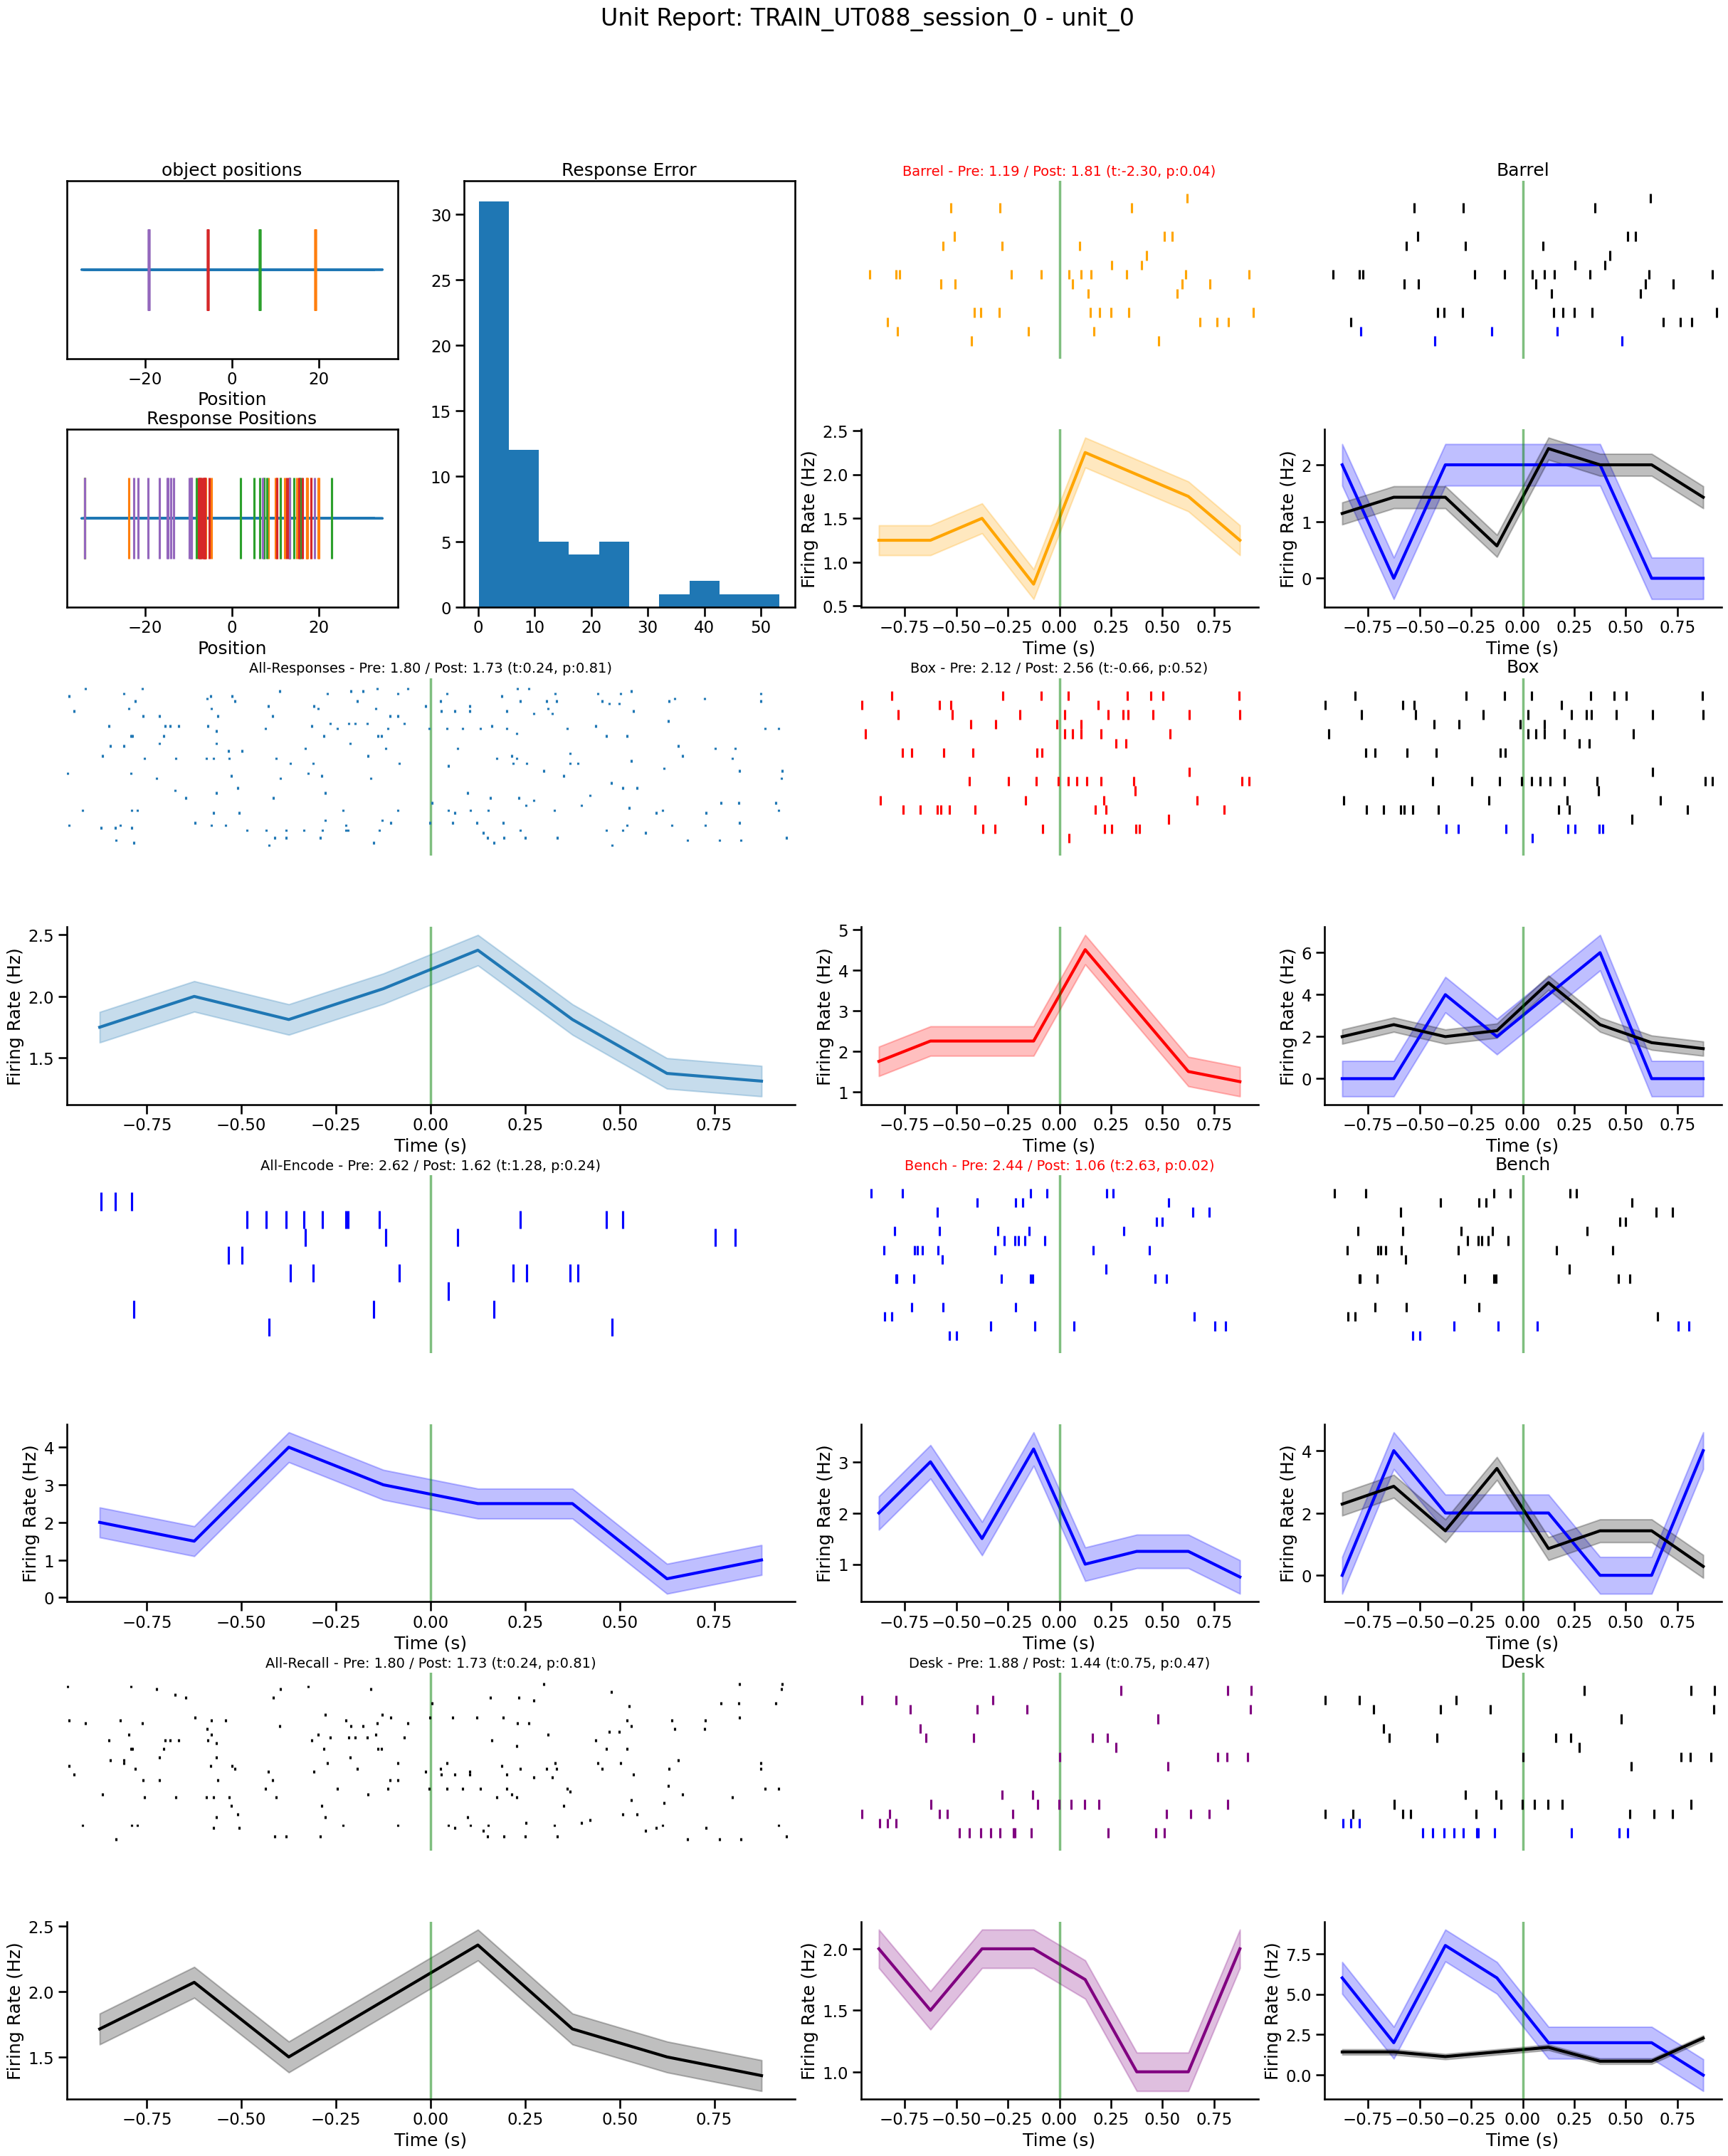

In [61]:
# Initialize figure with grid layout
grid = make_grid(8, 6, wspace=0.3, hspace=0.4, figsize=(30, 35),
                 width_ratios=[1, 1, .5, .5, .5,.5],
                 title=f'Unit Report: {session_name} - unit_{uind}')

plot_hist(nwbfile.trials['response_error'].data[:], title='Response Error',ax=get_grid_subplot(grid, slice(0, 2), slice(1, 2)))

plot_position_1d(positions, [barrel_loc,box_loc,desk_loc,bench_loc], ax=get_grid_subplot(grid, slice(0, 1), slice(0, 1)))
plt.title('object positions')
#plt.legend(['barrel', 'box', 'desk', 'bench'], loc='upper left', frameon=False, fontsize='large')

plot_position_1d(positions, [res_barrel_loc, res_box_loc, res_desk_loc, res_bench_loc],
                 title='Response Positions', ax=get_grid_subplot(grid, slice(1, 2), slice(0, 1)))
#plt.legend(['barrel', 'box', 'desk', 'bench'], loc='upper left', frameon=False, fontsize='large')


plot_rasters(all_responses,  xlim=trial_range, vline=0,title = create_raster_title('All-Responses', avg_pre, avg_post,
                                       t_val, p_val),
             title_color=color_pvalue(p_val), title_fontsize=14,
             ax=get_grid_subplot(grid, slice(2, 3), slice(0, 2)))
plot_rate_by_time(bin_times, all_frs.mean(0), shade='sem',ax=get_grid_subplot(grid, slice(3, 4), slice(0, 2)))
add_vlines(0, ax=get_grid_subplot(grid, slice(3, 4), slice(0, 2)), color='green', lw=2.5, alpha=0.5)
drop_spines(['top', 'right',],get_grid_subplot(grid, slice(3, 4), slice(0, 2)))


# Encoding 
avg_pre, avg_post, t_val, p_val = compare_pre_post_activity(all_encode, pre_window, post_window)
bin_times, encode_frs = compute_trial_frs(all_encode, 0.25, time_range=[-1,1])
plot_rasters(all_encode,  xlim=trial_range, vline=0, 
             colors= 'blue',title = create_raster_title('All-Encode', avg_pre, avg_post,t_val, p_val),
             title_color=color_pvalue(p_val), title_fontsize=14,
             ax=get_grid_subplot(grid, slice(4, 5), slice(0, 2)))
plot_rate_by_time(bin_times, encode_frs.mean(0), shade='sem',ax=get_grid_subplot(grid, slice(5, 6), slice(0, 2)), colors='blue')
add_vlines(0, ax=get_grid_subplot(grid, slice(5, 6), slice(0, 2)), color='green', lw=2.5, alpha=0.5)
drop_spines(['top', 'right',],get_grid_subplot(grid, slice(5, 6), slice(0, 2)))

# Recall
avg_pre, avg_post, t_val, p_val = compare_pre_post_activity(all_recall, pre_window, post_window)
bin_times, rec_frs = compute_trial_frs(all_recall, 0.25, time_range=[-1,1])

plot_rasters(all_recall,  xlim=trial_range, vline=0, 
             colors= 'black',title = create_raster_title('All-Recall', avg_pre, avg_post,
                                       t_val, p_val),
             title_color=color_pvalue(p_val), title_fontsize=14,
              ax=get_grid_subplot(grid, slice(6,7), slice(0, 2)))
plot_rate_by_time(bin_times, rec_frs.mean(0), shade='sem',ax=get_grid_subplot(grid, slice(7, 8), slice(0, 2)), colors='black')
add_vlines(0, ax=get_grid_subplot(grid, slice(7, 8), slice(0, 2)), color='green', lw=2.5, alpha=0.5)
drop_spines(['top', 'right',], ax=get_grid_subplot(grid, slice(7, 8), slice(0, 2)))


# Barrel 
plot_rasters(barrel_t,  xlim=trial_range, vline=0, 
             colors= 'orange',title = create_raster_title('Barrel', avg_pre_barrel, avg_post_barrel,
                                       results['t_val_barrel'], results['p_val_barrel']),
             title_color=color_pvalue(results['p_val_barrel']), title_fontsize=14,
              ax=get_grid_subplot(grid, slice(0, 1), slice(2, 4)))
plot_rate_by_time(bin_times, barrel_frs.mean(0), shade='sem',ax=get_grid_subplot(grid, slice(1, 2), slice(2, 4)), colors='orange')
add_vlines(0, ax=get_grid_subplot(grid, slice(1, 2), slice(2, 4)), color='green', lw=2.5, alpha=0.5)
drop_spines(['top', 'right',],get_grid_subplot(grid, slice(1, 2), slice(2, 4)))


# Barrel - Encoding vs Recall 
plot_rasters([barrel_encode,barrel_recall], xlim=trial_range, vline=0, colors= ['blue','black'],title = 'Barrel',
             ax=get_grid_subplot(grid, slice(0, 1), slice(4,6)))
plot_rate_by_time(bin_times, [barrel_frs_encode.mean(0),barrel_frs_recall.mean(0)], shade='sem', 
                  ax=get_grid_subplot(grid, slice(1, 2), slice(4,6)), colors=['blue','black'])
add_vlines(0, ax=get_grid_subplot(grid, slice(1, 2), slice(4,6)), color='green', lw=2.5, alpha=0.5)
drop_spines(['top', 'right'],get_grid_subplot(grid, slice(1, 2), slice(4,6)))

# Box 
plot_rasters(box_t,  xlim=trial_range, vline=0, 
             colors= 'red',title = create_raster_title('Box', avg_pre_box, avg_post_box,results['t_val_box'], results['p_val_box']),
             title_color=color_pvalue(results['p_val_box']), title_fontsize=14,
             ax=get_grid_subplot(grid, slice(2, 3), slice(2, 4)))
plot_rate_by_time(bin_times, box_frs.mean(0), shade='sem', ax=get_grid_subplot(grid, slice(3, 4), slice(2, 4)), colors='red')
add_vlines(0, ax=get_grid_subplot(grid, slice(3, 4), slice(2, 4)), color='green', lw=2.5, alpha=0.5)
drop_spines(['top', 'right',],get_grid_subplot(grid, slice(3, 4), slice(2, 4)))
# Box - Encoding vs Recall 
plot_rasters([box_encode,box_recall], xlim=trial_range, vline=0, colors= ['blue','black'],title = 'Box',
            ax=get_grid_subplot(grid, slice(2, 3), slice(4,6)))

plot_rate_by_time(bin_times, [box_frs_encode.mean(0),box_frs_recall.mean(0)], shade='sem', 
                  ax=get_grid_subplot(grid, slice(3, 4), slice(4,6)), colors=['blue','black'])
add_vlines(0, ax=get_grid_subplot(grid, slice(3, 4), slice(4,6)), color='green', lw=2.5, alpha=0.5)
drop_spines(['top', 'right'],get_grid_subplot(grid, slice(3, 4), slice(4,6)))

# Bench 
plot_rasters(bench_t,  xlim=trial_range, vline=0, 
             colors= 'blue',title = create_raster_title('Bench', avg_pre_bench, avg_post_bench,results['t_val_bench'], results['p_val_bench']),
             title_color=color_pvalue(results['p_val_bench']), title_fontsize=14,
            ax=get_grid_subplot(grid, slice(4, 5), slice(2,4)))
plot_rate_by_time(bin_times, bench_frs.mean(0), shade='sem', 
                  ax=get_grid_subplot(grid, slice(5, 6), slice(2,4)), colors='blue')
add_vlines(0, ax=get_grid_subplot(grid, slice(5,6), slice(2,4)), color='green', lw=2.5, alpha=0.5)
drop_spines(['top', 'right',],ax=get_grid_subplot(grid, slice(5, 6), slice(2,4)))

# Bench-Encoding and Recall 
plot_rasters([bench_encode,bench_recall], xlim=trial_range, vline=0, 
             colors= ['blue','black'],title = 'Bench',
             ax=get_grid_subplot(grid, slice(4,5), slice(4,6)))
plot_rate_by_time(bin_times, [bench_frs_encode.mean(0),bench_frs_recall.mean(0)], shade='sem', 
                  ax=get_grid_subplot(grid, slice(5,6), slice(4,6)), colors=['blue','black'])
add_vlines(0,ax=get_grid_subplot(grid, slice(5,6), slice(4,6)), color='green', lw=2.5, alpha=0.5)
drop_spines(['top', 'right'],get_grid_subplot(grid, slice(5,6), slice(4,6)))

# Desk 
plot_rasters(desk_t,  xlim=trial_range, vline=0, 
             colors= 'purple',title = create_raster_title('Desk', avg_pre_desk, avg_post_desk,
                                       results['t_val_desk'], results['p_val_desk']),
             title_color=color_pvalue(results['p_val_desk']), title_fontsize=14,
             ax=get_grid_subplot(grid, slice(6, 7), slice(2,4)))

plot_rate_by_time(bin_times, desk_frs.mean(0), shade='sem', 
                  ax=get_grid_subplot(grid, slice(7, 8), slice(2,4)), colors='purple')
add_vlines(0, ax=get_grid_subplot(grid, slice(7, 8), slice(2,4)), color='green', lw=2.5, alpha=0.5)
drop_spines(['top', 'right',],ax=get_grid_subplot(grid, slice(7, 8), slice(2,4)))

# Desk - Encoding and Recall 
plot_rasters([desk_encode,desk_recall], xlim=trial_range, vline=0, 
             colors= ['blue','black'],title = 'Desk',
             ax=get_grid_subplot(grid, slice(6, 7), slice(4,6)))

plot_rate_by_time(bin_times, [desk_frs_encode.mean(0),desk_frs_recall.mean(0)], shade='sem', ax=get_grid_subplot(grid, slice(7, 8), slice(4,6)), colors=['blue','black'])
add_vlines(0, ax=get_grid_subplot(grid, slice(7, 8), slice(4,6)), color='green', lw=2.5, alpha=0.5)
drop_spines(['top', 'right'],ax=get_grid_subplot(grid, slice(7, 8), slice(4,6)))



